# deep learning study

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
proliferation_df = pd.read_excel("data/1-s2.0-S0092867415011952-mmc2.xlsx").iloc[1:, :5]
proliferation_df.columns = proliferation_df.iloc[0]
proliferation_df = proliferation_df.drop(proliferation_df.index[0])
proliferation_df = proliferation_df[["Case.ID", "ProliferationScore"]]
proliferation_df["Case.ID"] = proliferation_df["Case.ID"].apply(lambda x: x + "-01")
proliferation_df["ProliferationScore"] = proliferation_df["ProliferationScore"].astype(float)

In [44]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np

from rpy2.robjects.conversion import localconverter

In [45]:
with localconverter(ro.default_converter + pandas2ri.converter):
    proliferation_df_r = ro.conversion.py2rpy(proliferation_df)
proliferation_df_r.to_csvfile("data/proliferation_df.csv")

/Users/szalata/anaconda3/envs/ada/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "Case.ID". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


<rpy2.rinterface_lib.sexp.NULLType object at 0x117d893c0> [RTYPES.NILSXP]

In [594]:
ro.r['load']("data/norm.Rda")
ro.r['load']("data/colnames.Rda");

In [165]:
colnames = pd.DataFrame(ro.r["columns"])

In [595]:
expression_array = np.array(ro.r["rpkm"]).reshape((-1, 816))

In [170]:
proliferation = colnames.merge(proliferation_df, left_on=0, right_on="Case.ID")["ProliferationScore"]

In [64]:
expression_array.shape

(13924, 816)

In [75]:
from torch.utils.data import DataLoader,Dataset

In [107]:
class noisedDataset(Dataset):  
    def __init__(self, dataset_array, noise_std=2):
        self.data_array = expression_array.T
        self.noise_std = noise_std
  
    def __len__(self):
        return len(self.data_array)
  
    def __getitem__(self,idx):
        clean = self.data_array[idx]
        noised = clean + torch.empty(clean.shape).normal_(mean=0,std=self.noise_std).detach().numpy()
    
        noised = torch.Tensor(noised)
        clean = torch.Tensor(clean)
        return clean, noised

In [137]:
trainset = noisedDataset(expression_array)
testset = torch.Tensor(expression_array.T)

In [109]:
batch_size=128

trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size=batch_size,shuffle=False)

# DA model

In [130]:
import torch.nn as nn
import torch


class autoencoder(nn.Module):
    def __init__(self, n_features):
        super(autoencoder, self).__init__()
        first_FC = n_features//8
        self.encoder = nn.Sequential(
            nn.Linear(n_features, first_FC),
            nn.BatchNorm1d(first_FC),
            nn.ReLU(True),
            nn.Linear(first_FC, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(100, first_FC),
            nn.BatchNorm1d(first_FC),
            nn.ReLU(True),
            nn.Linear(first_FC, n_features))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

In [131]:
model = autoencoder(len(expression_array))
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 2000


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for clean, noised in trainloader:     
        clean, noised = clean, noised  
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noised)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, clean)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * clean.size(0)
            
    # print avg training statistics 
    if epoch % 50 == 0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for clean in testloader:
                clean = clean  
                outputs = model(clean)
                loss = criterion(outputs, clean)
                test_loss += loss.item() * clean.size(0)
        model.train()
        test_loss = test_loss/len(testloader)
        print('Epoch: {} \tTesting Loss: {:.6f}'.format(
            epoch, 
            test_loss
            ))

In [ ]:
torch.save(model.state_dict(), "data/model.pt")

In [134]:
model.load_state_dict(torch.load("data/model.pt"))
model.eval();

In [147]:
encoded_expression = model.encode(testset).detach().numpy()

In [1000]:
encoded_expression.shape

(816, 100)

# Survival regression

Only based on the 100 differential genes wrt proliferation

In [1001]:
clinical_df = pd.read_csv("data/data_clinical_patient.txt", sep="\t").iloc[4:, [0, 5, -4, -3]]
clinical_df["#Patient Identifier"] = clinical_df["#Patient Identifier"].apply(lambda x: x.replace(".", "-") + "-01")
clinical_df["Overall Survival Status"] = pd.Categorical(clinical_df["Overall Survival Status"])
clinical_df["Overall Survival Status"] = clinical_df["Overall Survival Status"].cat.codes
clinical_df["Overall Survival Status"] = clinical_df["Overall Survival Status"].apply(lambda x: 0 if x == 1 else 1)
clinical_df = clinical_df[clinical_df["Overall Survival (Months)"] != "[Not Available]"]
clinical_df = clinical_df[clinical_df["Birth from Initial Pathologic Diagnosis Date"] != "[Not Available]"]
clinical_df["Overall Survival (Months)"] = clinical_df["Overall Survival (Months)"].astype(float)

In [1003]:
clinical_data.shape

(801, 5)

In [1002]:
clinical_data = colnames.merge(clinical_df, left_on=0, right_on="#Patient Identifier")
indices_clinical = clinical_data.index

In [975]:
from lifelines import CoxPHFitter

In [976]:
reduced_expression_array = pd.DataFrame(np.copy(expression_array.T))

In [ ]:
# this doesn't converge due to high collinearity of the expression matrix

expression_df = pd.DataFrame(expression_array.T[indices_clinical])
expression_df["duration"] = clinical_data["Overall Survival (Months)"]
expression_df["event"] = clinical_data["Overall Survival Status"]

cph = CoxPHFitter()
cph.fit(expression_df, duration_col="duration", event_col="event")

cph.print_summary()

100 PCA components from all the expressions

In [980]:
# doing PCA to remove collinearity and select only relevant components

from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(expression_array);

In [981]:
expression_df = pd.DataFrame(pca.components_.T[indices_clinical])
expression_df["duration"] = clinical_data["Overall Survival (Months)"]
expression_df["event"] = clinical_data["Overall Survival Status"]
expression_df["diagnosis_time"] = clinical_data["Birth from Initial Pathologic Diagnosis Date"]

cph = CoxPHFitter()
cph.fit(expression_df, duration_col="duration", event_col="event");
cph.concordance_index_

/Users/szalata/anaconda3/envs/ada/lib/python3.7/site-packages/lifelines/utils/__init__.py:1095: ConvergenceWarning: Column(s) [0] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


0.7588474955396373

Only age as predictor

In [982]:
encoded_expression_df = pd.DataFrame()
encoded_expression_df["duration"] = clinical_data["Overall Survival (Months)"]
encoded_expression_df["event"] = clinical_data["Overall Survival Status"]
encoded_expression_df["diagnosis age"] = -clinical_data["Birth from Initial Pathologic Diagnosis Date"].astype(int)/365

cph = CoxPHFitter()
cph.fit(encoded_expression_df, duration_col="duration", event_col="event")

cph.concordance_index_

0.6373658562564908

Expression summary from autoencode

In [987]:
encoded_expression_df = pd.DataFrame(encoded_expression[indices_clinical])
encoded_expression_df["duration"] = clinical_data["Overall Survival (Months)"]
encoded_expression_df["event"] = clinical_data["Overall Survival Status"]
encoded_expression_df["diagnosis age"] = -clinical_data["Birth from Initial Pathologic Diagnosis Date"].astype(int)/365

cph = CoxPHFitter()
cph.fit(encoded_expression_df, duration_col="duration", event_col="event")

cph.concordance_index_

0.8097622027534418

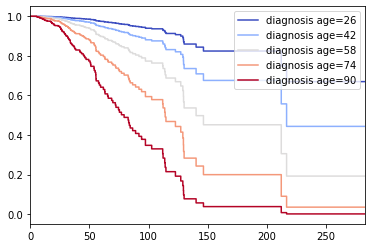

In [988]:
cph.plot_covariate_groups("diagnosis age", np.linspace(encoded_expression_df["diagnosis age"].min(),
                                                       encoded_expression_df["diagnosis age"].max(), 5).astype(int),
                          cmap='coolwarm', plot_baseline=False);

top 100 differentially expressed genes wrt proliferation score

In [985]:
ro.r['load']("data/rownames.Rda")
rownames = pd.DataFrame(ro.r["rows"])
rownames[0] = rownames[0].astype(int)
rownames.reset_index(inplace=True)

proliferation_differential_genes = pd.DataFrame(ro.r["high.vs.low.proliferation.topgenes"])
proliferation_expression = expression_array[rownames.merge(proliferation_differential_genes, left_on=0, right_on=0)["index"], :].T

proliferation_df = pd.DataFrame(proliferation_expression[indices_clinical])
proliferation_df["duration"] = clinical_data["Overall Survival (Months)"]
proliferation_df["event"] = clinical_data["Overall Survival Status"]
proliferation_df["diagnosis_time"] = clinical_data["Birth from Initial Pathologic Diagnosis Date"]


cph = CoxPHFitter()
cph.fit(proliferation_df, duration_col="duration", event_col="event")

cph.concordance_index_

0.7690730434319495

In [1007]:
encoded_expression_df["event"].sum()

118